# Tools for radio-image fitting

This notebooks contains sets of tools to perform image fitting to radio-images using scipy and LMTIT, analyse results and analyse results from image decomposition made by IMFIT. This notebook is integrated with casa, so it operates on numpy-arrays, CASA tasks and astropy+scipy capabilities.

In [1]:
# cd GitHubUoM/phd_lucatelli_work/analysis

## Table of Contents

1. [Introduction](#intro) <br>
2. [Source Extraction](#source_extr) <br>
3. [Image fitting with Scipy/LMFIT](#image-fit-lmfit) <br>

    1. [Image fitting with Scipy/LMFIT](#image-fit-lmfit)
    2. Image analysis (non-parametric)
    3. Plotting capabilities
    4. Signal processing

<!-- ## Introduction <a id='intro'></a> -->

<a id='intro'></a>
```
 _            ___       _                 _            _   _             
/ |          |_ _|_ __ | |_ _ __ ___   __| |_   _  ___| |_(_) ___  _ __  
| |  _____    | || '_ \| __| '__/ _ \ / _` | | | |/ __| __| |/ _ \| '_ \ 
| | |_____|   | || | | | |_| | | (_) | (_| | |_| | (__| |_| | (_) | | | |
|_|          |___|_| |_|\__|_|  \___/ \__,_|\__,_|\___|\__|_|\___/|_| |_|

```

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import casatasks
from casatasks import *
import casatools
# from casatools import *
from scipy.ndimage import rotate
# import analysisUtils as au
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
from casatools import image as IA
import lmfit
import string
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import glob
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import os
from astropy.stats import mad_std
from scipy.ndimage import gaussian_filter
from astropy import visualization
from astropy.visualization import simple_norm
from astropy.convolution import Gaussian2DKernel
import scipy.special as sp
from matplotlib import rcParams,rc
from libs import *
from libs import Gradindex
from libs import polarim
try:
    import casaviewer.imview as imview
except:
    pass


def reset_rc_params():
    mpl.rcParams.update({'font.size': 14, 
        'mathtext.fontset': 'stix',
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.family": "sans",
        "font.serif": ["Exo 2"],
        "font.sans-serif": ["Exo 2"],
        'font.family': 'STIXGeneral', 
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'axes.labelsize' : 16,
        'xtick.major.width':1,
        'ytick.major.width':1,
        'axes.linewidth':1,
        'lines.linewidth':2,
        'legend.fontsize':14,
        "grid.linestyle":'--',                
        })
    pass
reset_rc_params()



                                                          ..___|**_               
                                                  .|||||||||*+@+*__*++.           
                                              _||||.           .*+;].,#_          
                                         _|||*_                _    .@@@#@.       
                                   _|||||_               .@##@#| _||_             
   Radio Morphen              |****_                   .@.,/\..@_.                
                             #///#+++*|    .       .@@@;#.,.\@.                   
                              .||__|**|||||*||*+@#];_.  ;,;_                      
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]                        
                                               ;@       @.*.                      
                                                #|       _;]];|.                  
                           

In [3]:
import sys
# sys.path.append('../../scripts/analysis_scripts/')
sys.path.append('analysis_scripts/')
sys.path.append('/opt/casa-6.5.1-23-py3.8/')


In [4]:
pwd

'/home/sagauga/pCloudDrive/GitHubUoM/phd_lucatelli_work/analysis'

In [5]:
import analysisUtils as au

You appear to be importing analysisUtils into python (not CASA). version =  3.8.16
CASAPATH is not defined, so I am skipping a lot of imports


In [6]:
from analysisUtils import *

In [7]:
# root_path  = '/run/media/sagauga/storage_wd_2/cloud/onedirve_UoM/PhD/'
root_path  = '../../../PhD/'

## Load List of Images (and their cleaning residuals)

In [8]:
# em_list,em_list_re = get_list_names(root_path=root_path,prefix='*-MFS-image.fits',which_data='eMERLIN_only',source='UGC8696_C')
em_list,em_list_re = get_list_names(root_path=root_path,prefix='*-MFS-image.cutout.fits',which_data='eMERLIN_only',source='UGC8696_C',cutout_folder='cutouts/')
# comb_list,comb_list_re = get_list_names(root_path=root_path,prefix='*taper_0.05asec*-MFS-image.cutout.fits',which_data='combined_data',source='UGC8696_C',cutout_folder='cutouts/')

0 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..-1.5-MFS-image.cutout.fits
1 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..-1.0-MFS-image.cutout.fits
2 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..-0.5-MFS-image.cutout.fits
3 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..0.0-MFS-image.cutout.fits
4 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..0.5-MFS-image.cutout.fits
5 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerlin_combined_selfcalibrated_3072_0.006arcsec_5000.briggs.-multiscale..1.0-MFS-image.cutout.fits
6 >> clean_image_sw_10.0_LE1014_C_L24_UGC8696_1344+5553_emerl

Lets use a intermediate image between JVLA and e-MERLIN. E.G. one with a robust parameter of 0.0 should be fine (note that the index from the list is `5`) . Lets also loat its residual image.

In [9]:
crop_image = em_list[9]
crop_residual = em_list_re[9]

We can plot these images. I am going to use the help function called `fast_plot2`.

Not plotting contours!


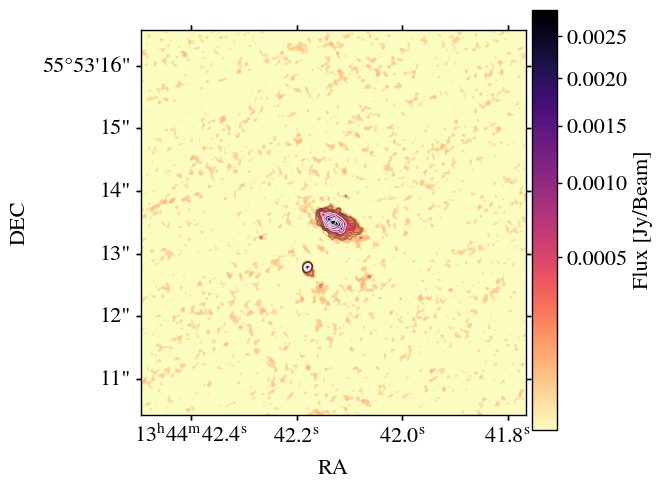

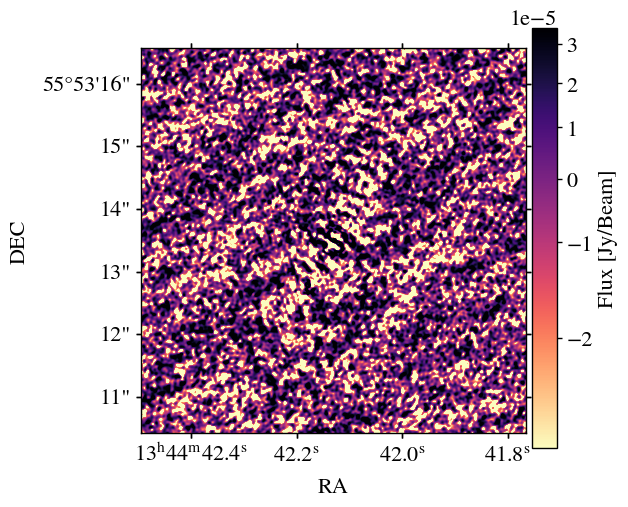

In [10]:
fast_plot2(crop_image)
fast_plot2(crop_residual,vmin_factor=-1.)

<a id='source_extr'></a>

```
 ____             ____                             _____      _                  _   _             
|___ \           / ___|  ___  _   _ _ __ ___ ___  | ____|_  _| |_ _ __ __ _  ___| |_(_) ___  _ __  
  __) |  _____   \___ \ / _ \| | | | '__/ __/ _ \ |  _| \ \/ / __| '__/ _` |/ __| __| |/ _ \| '_ \ 
 / __/  |_____|   ___) | (_) | |_| | | | (_|  __/ | |___ >  <| |_| | | (_| | (__| |_| | (_) | | | |
|_____|          |____/ \___/ \__,_|_|  \___\___| |_____/_/\_\\__|_|  \__,_|\___|\__|_|\___/|_| |_|

````

In order to implement a better way for image fitting onto simple or complex radio sources, it is a good idea to first analyse the images in order to check the background noise emission and perform a simple segmentation and component extraction from the radio emission.

For that, we use here the SEP python package. A help function using it was created and placed in the ```libs.py``` file:

In [11]:
sep_source_ext??

-6.521096906908497e-08
2.3590391720063053e-05
Not plotting contours!
object 0: flux = 0.065726 +/- 0.256372
object 1: flux = 0.141839 +/- 0.376616


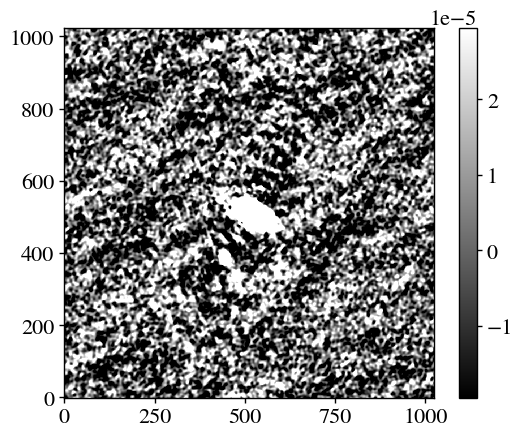

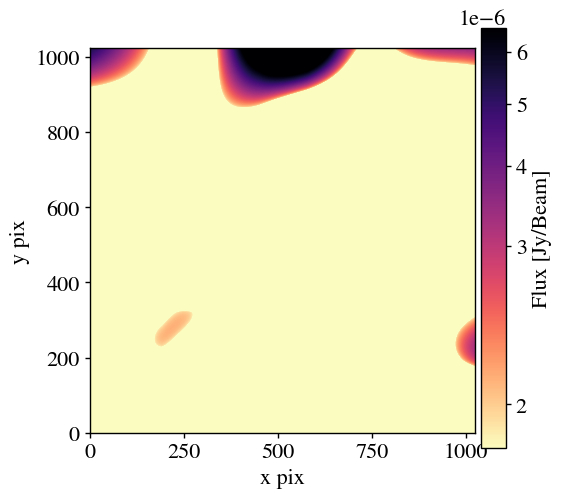

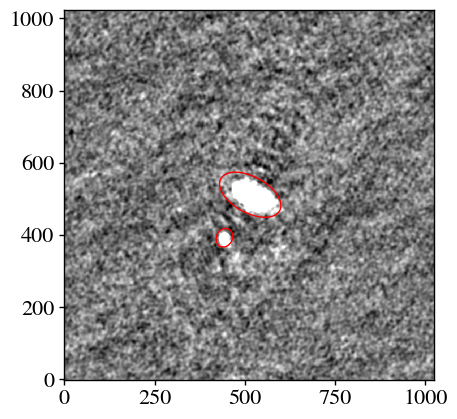

In [12]:
"""
Note, the following values for the background estimation in order to 
extract components are very conservative.  They arre effective on noise and 
outliers, but the resulting data (data - bkg) MUST not be used to compute flux. 

That is left for anoter part of the analysis.
"""
masks, indices = sep_source_ext(crop_image,bw=128,bh=128,fw=3,fh=3,
                                sigma=15,ell_size_factor=5,apply_mask=False)

Now, we have ellipses indicating where sub-components are located on the image. 

We also have the associated masks.

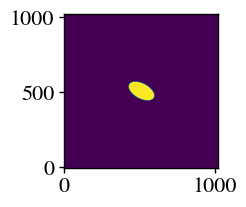

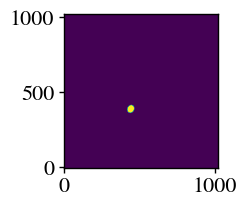

In [13]:
# indices are the indices of each mask in descending order. 
for i in indices:
    plt.figure(figsize=(2,2))
    plt.imshow(masks[i],origin='lower')

We can not estimate the flux yet, because we do not know for sure the limit extension of each component. 

For that, we need some another analysis, such as a Petrosian analysis. 

We have a help function called 

To load the `.fits` image data, just do:

In [14]:
data_2D = ctn(crop_image)

In [15]:
sigma_level = 3
vmin = 3

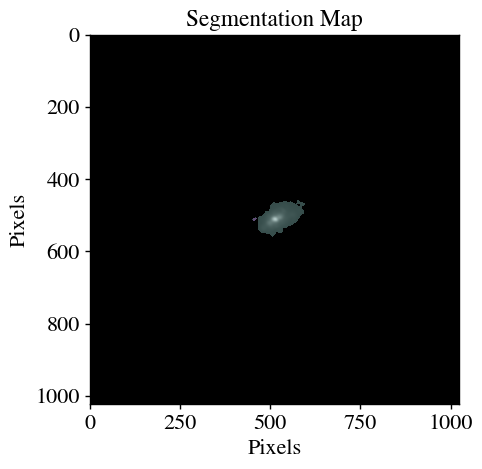

In [16]:
source_props = {}
i = 0 #to be used in indices[0], e.g. first component
ii = str(i+1)
mask_component = masks[indices[i]]
data_component = data_2D*mask_component
cat, segm, segm_deblend = make_catalog(
    image=data_component,
    threshold=sigma_level * mad_std(data_2D),
    deblend=False, #because we already deblended it!
    plot=True, vmax=data_2D.max(), vmin=vmin * mad_std(data_2D)
)

source = cat[0]

source_props['c' + ii + '_PA'] = source.orientation.value
source_props['c' + ii + '_q'] = 1 - source.ellipticity.value
source_props['c' + ii + '_area'] = source.area.value
source_props['c' + ii + '_Re'] = source.equivalent_radius.value
source_props['c' + ii + '_x0c'] = source.xcentroid
source_props['c' + ii + '_y0c'] = source.ycentroid
source_props['c' + ii + '_label'] = source.label

In [17]:
source_props

{'c1_PA': -28.026729628184267,
 'c1_q': 0.5356886119067006,
 'c1_area': 8331.0,
 'c1_Re': 51.49601597985188,
 'c1_x0c': 517.4572009563765,
 'c1_y0c': 510.34321092454877,
 'c1_label': 1}

1


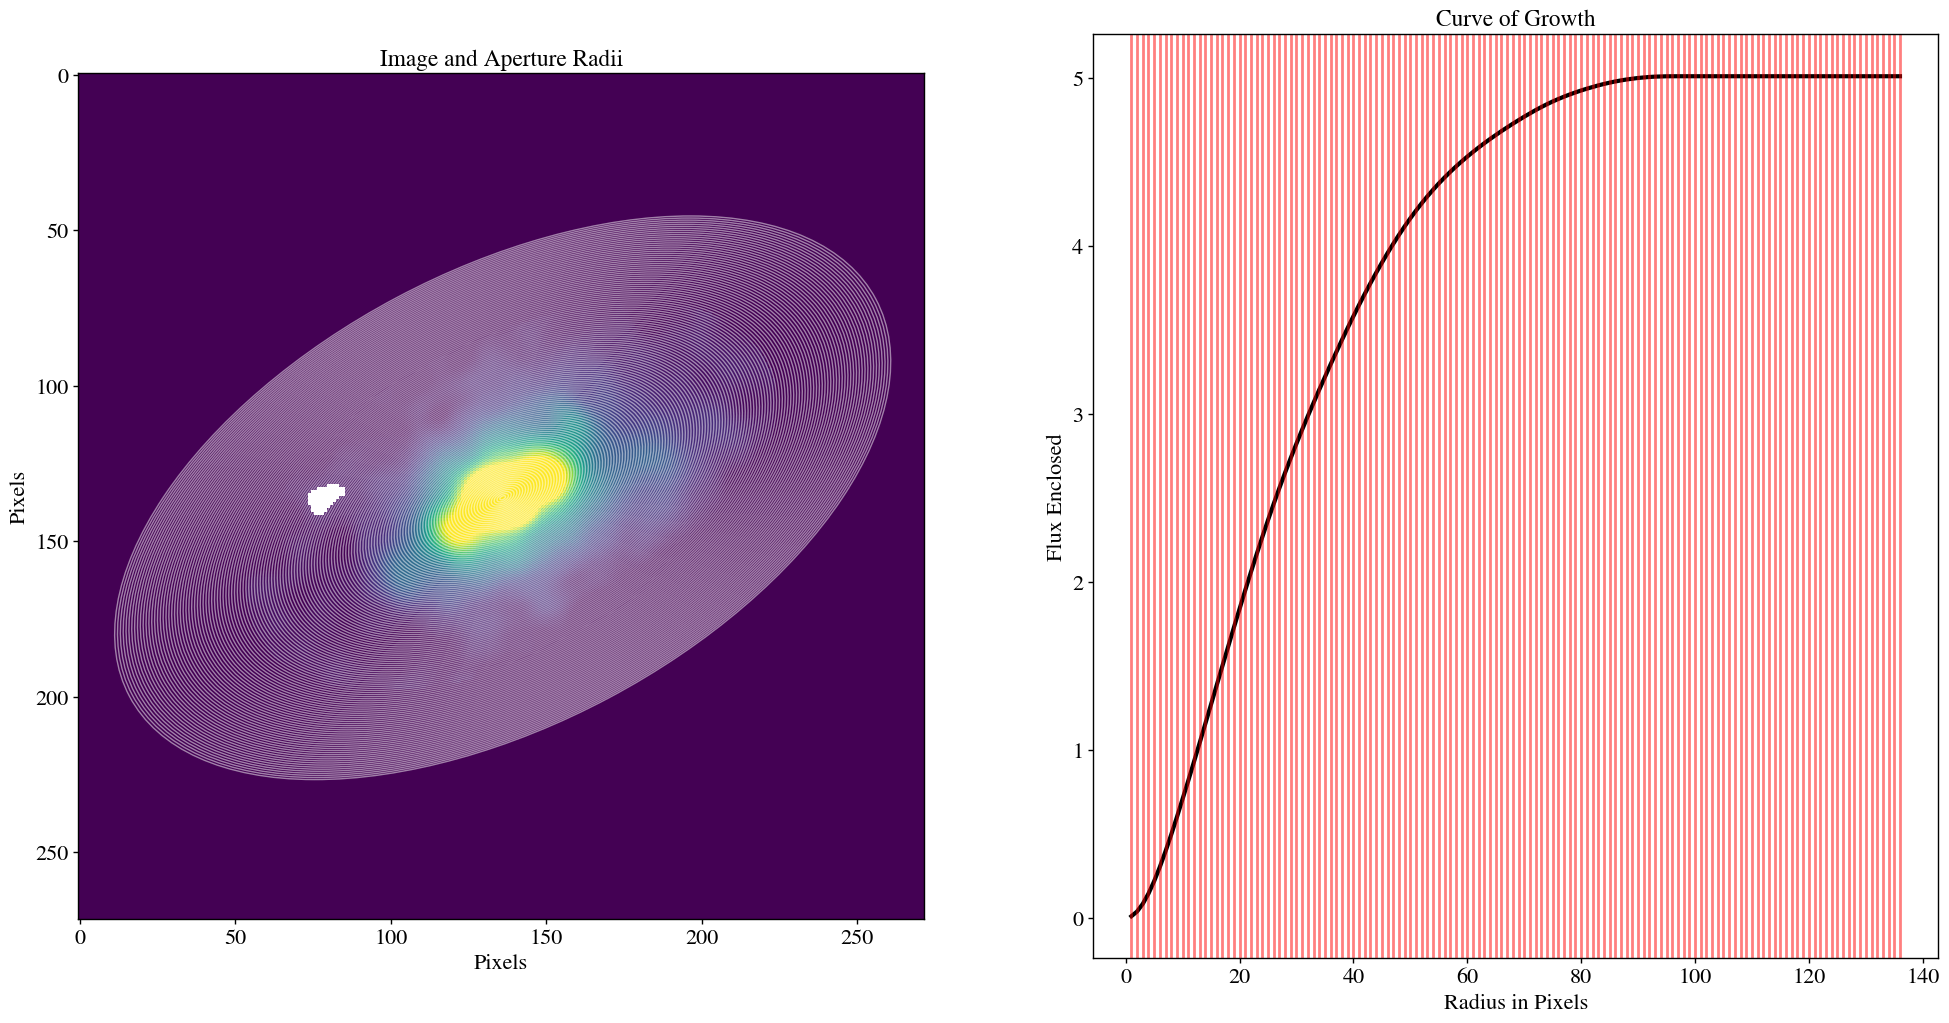

26.41648329665933 5.013439000000001 59.03580716143228


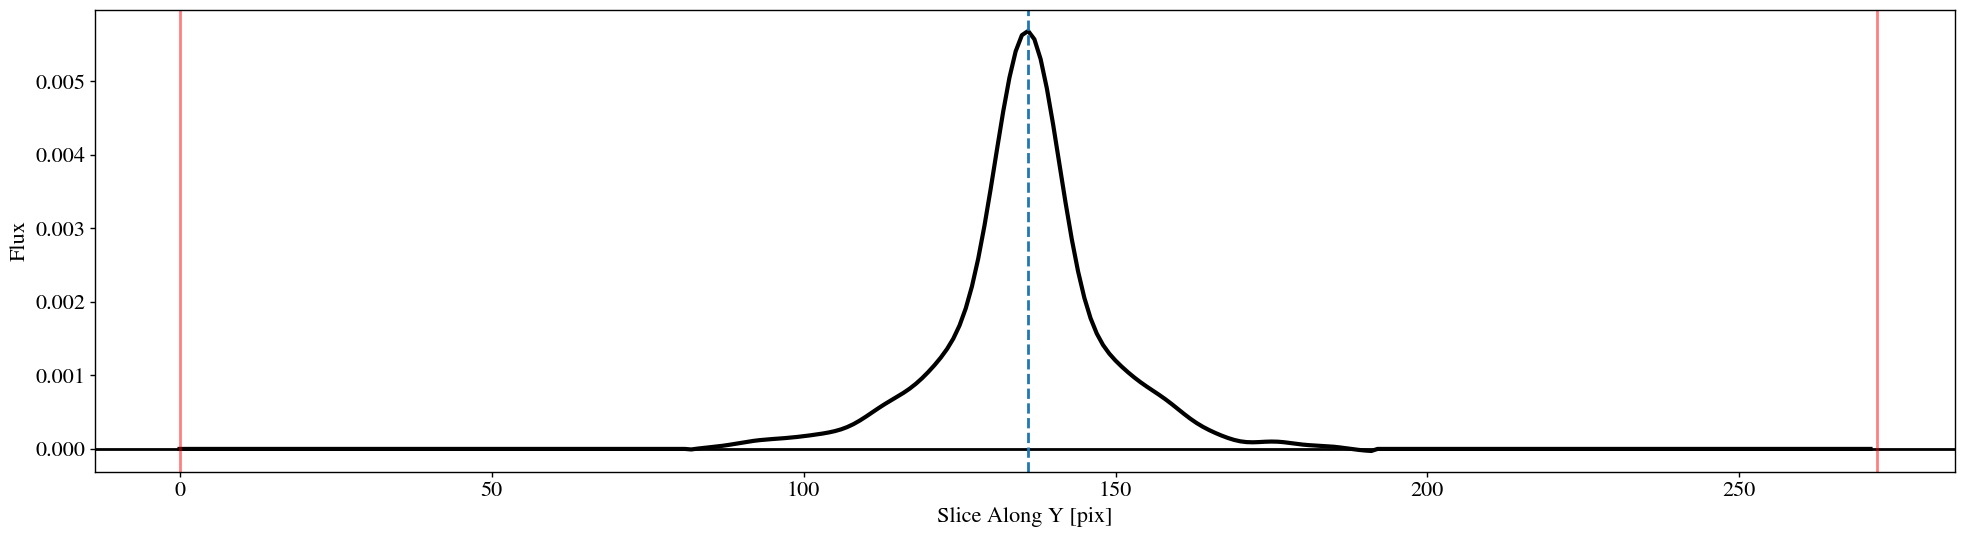

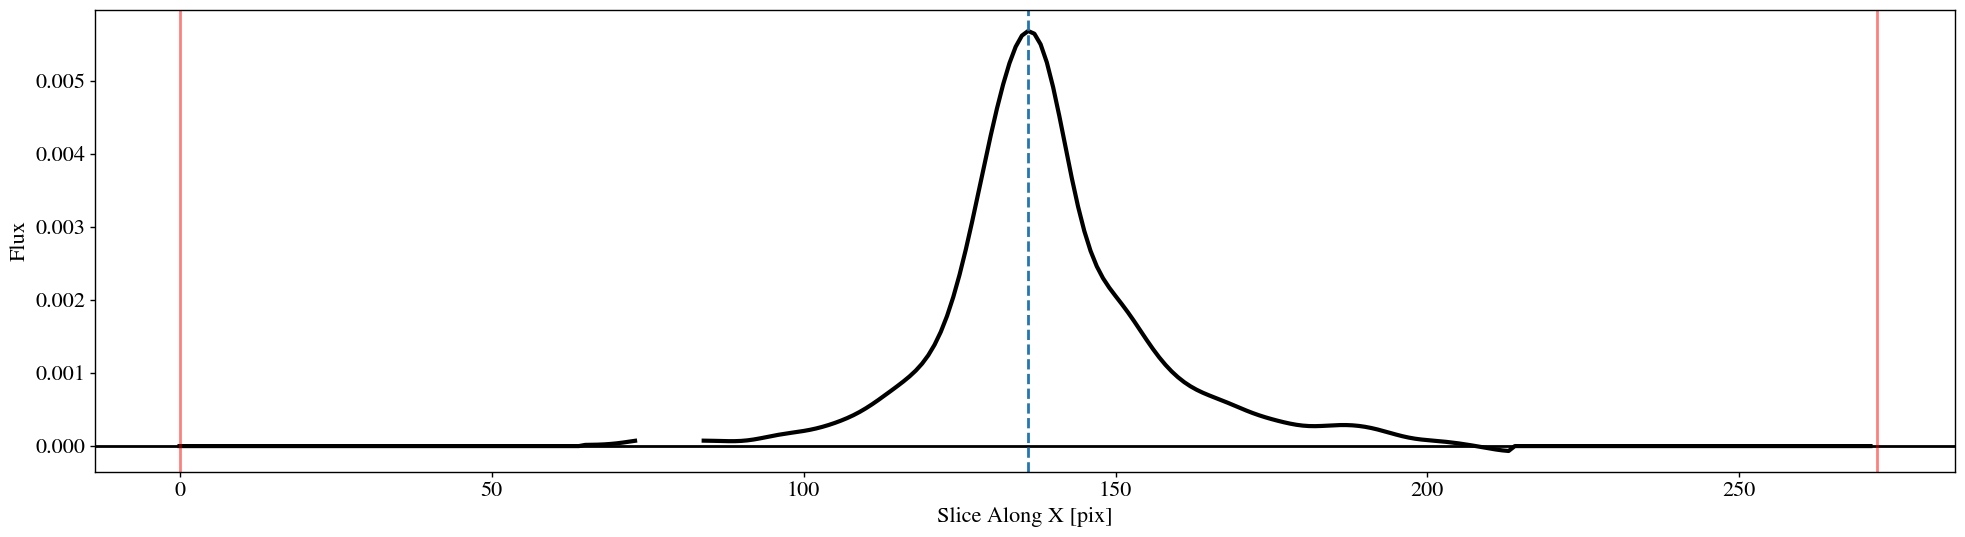

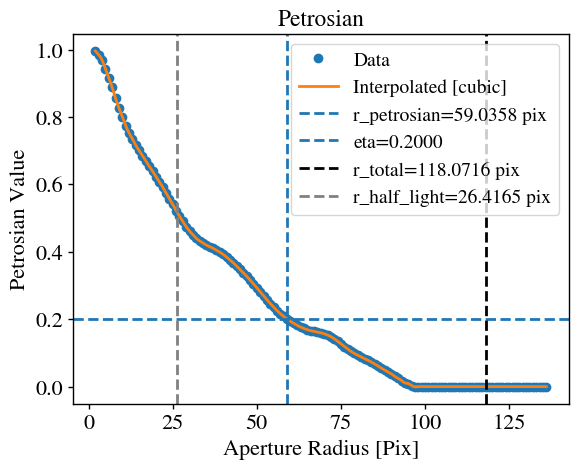

In [18]:
rlast = int(2 * np.sqrt((np.sum(mask_component) / np.pi)))
r_list = make_radius_list(
    max_pix=rlast,  # Max pixel to go up to
    n=int(rlast)  # the number of radii to produce
)
bkg_sub = False
sigma = sigma_level
plot = True
sigma_type='clip'
cutout_size = 2 * max(r_list)
flux_arr, area_arr, error_arr = source_photometry(source, data_component, segm,
                                                  r_list, cutout_size=cutout_size,
                                                  bkg_sub=bkg_sub, sigma=sigma,
                                                  sigma_type=sigma_type,
                                                  plot=plot, vmax=0.3 * data_component.max(),
                                                  vmin=vmin * mad_std(data_component)
                                                  )
p = Petrosian(r_list, area_arr, flux_arr)
R50 = p.r_half_light
Snu = p.total_flux
Rp = p.r_petrosian
plt.figure()
p.plot(plot_r=plot)

print(R50,Snu,Rp)


### Lets put all into a function:

In [19]:
def compute_petro_source(data_2D, mask_component,i=0,source_props={},
                         sigma_level = 3, bkg_sub=False,
                         vmin=1, plot = False, deblend = False,):
    
    # if mask:
    ii = str(i+1)
    data_component = data_2D * mask_component
    cat, segm, segm_deblend = make_catalog(image=data_component,
                                           threshold=sigma_level * mad_std(data_component),
                                           deblend=deblend, #because we already deblended it!
                                           plot=plot, vmax=data_component.max(), 
                                           vmin=vmin * mad_std(data_component))

    source = cat[0]

    source_props['c' + ii + '_PA'] = source.orientation.value
    source_props['c' + ii + '_q'] = 1 - source.ellipticity.value
    source_props['c' + ii + '_area'] = source.area.value
    source_props['c' + ii + '_Re'] = source.equivalent_radius.value
    source_props['c' + ii + '_x0c'] = source.xcentroid
    source_props['c' + ii + '_y0c'] = source.ycentroid
    source_props['c' + ii + '_label'] = source.label
    
    #help function to be used if iteration required.
    source_props = petro_params(source=source, data_2D=data_component, segm=segm,
                            mask_source=mask_component,
                            i=ii, petro_properties=source_props,
                            rlast=None, sigma=sigma_level,
                            vmin=vmin, bkg_sub=bkg_sub,
                            plot=plot)

    """
    Check if Rp is larger than last element (rlast) of the R_list. If yes, 
    we need to run petro_params again, with a larger rlast, at least r_last>=Rp.
    If not, R50 will be np.nan as well Snu. 
    """
    if source_props['c' + ii + '_rlast'] < 2 * source_props['c' + ii + '_Rp']:
        Rlast_new = 2 * source_props['c' + ii + '_Rp'] + 3
        source_props = petro_params(source=source, data_2D=data_component,
                                    segm=segm,mask_source=mask_component,
                                    i=ii, petro_properties=source_props,
                                    rlast=Rlast_new, sigma=sigma_level,
                                    vmin=vmin,
                                    bkg_sub=bkg_sub, plot=plot)

    """
    Now, estimate the effective intensity.
    """
    r, ir = get_profile(data_component, binsize=1.0)
    try:
        I50 = ir[int(source_props['c' + ii + '_R50'])]
    except:
        source_props['c' + ii + '_R50'] = source_props['c' + ii + '_Re']/2
        I50 = ir[int(source_props['c' + ii + '_R50'])]
        # I50 = ir[0]*0.1

    source_props['c' + ii + '_I50'] = I50
    
    return(source_props)

    

1


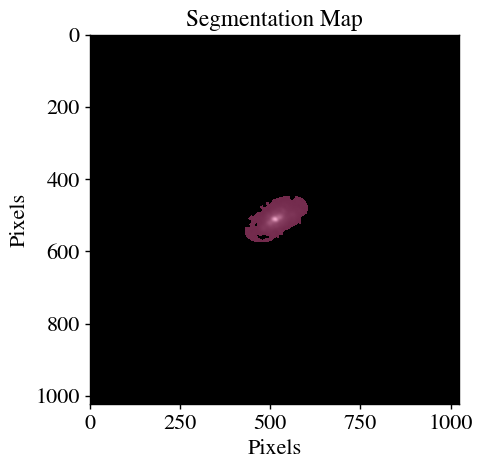

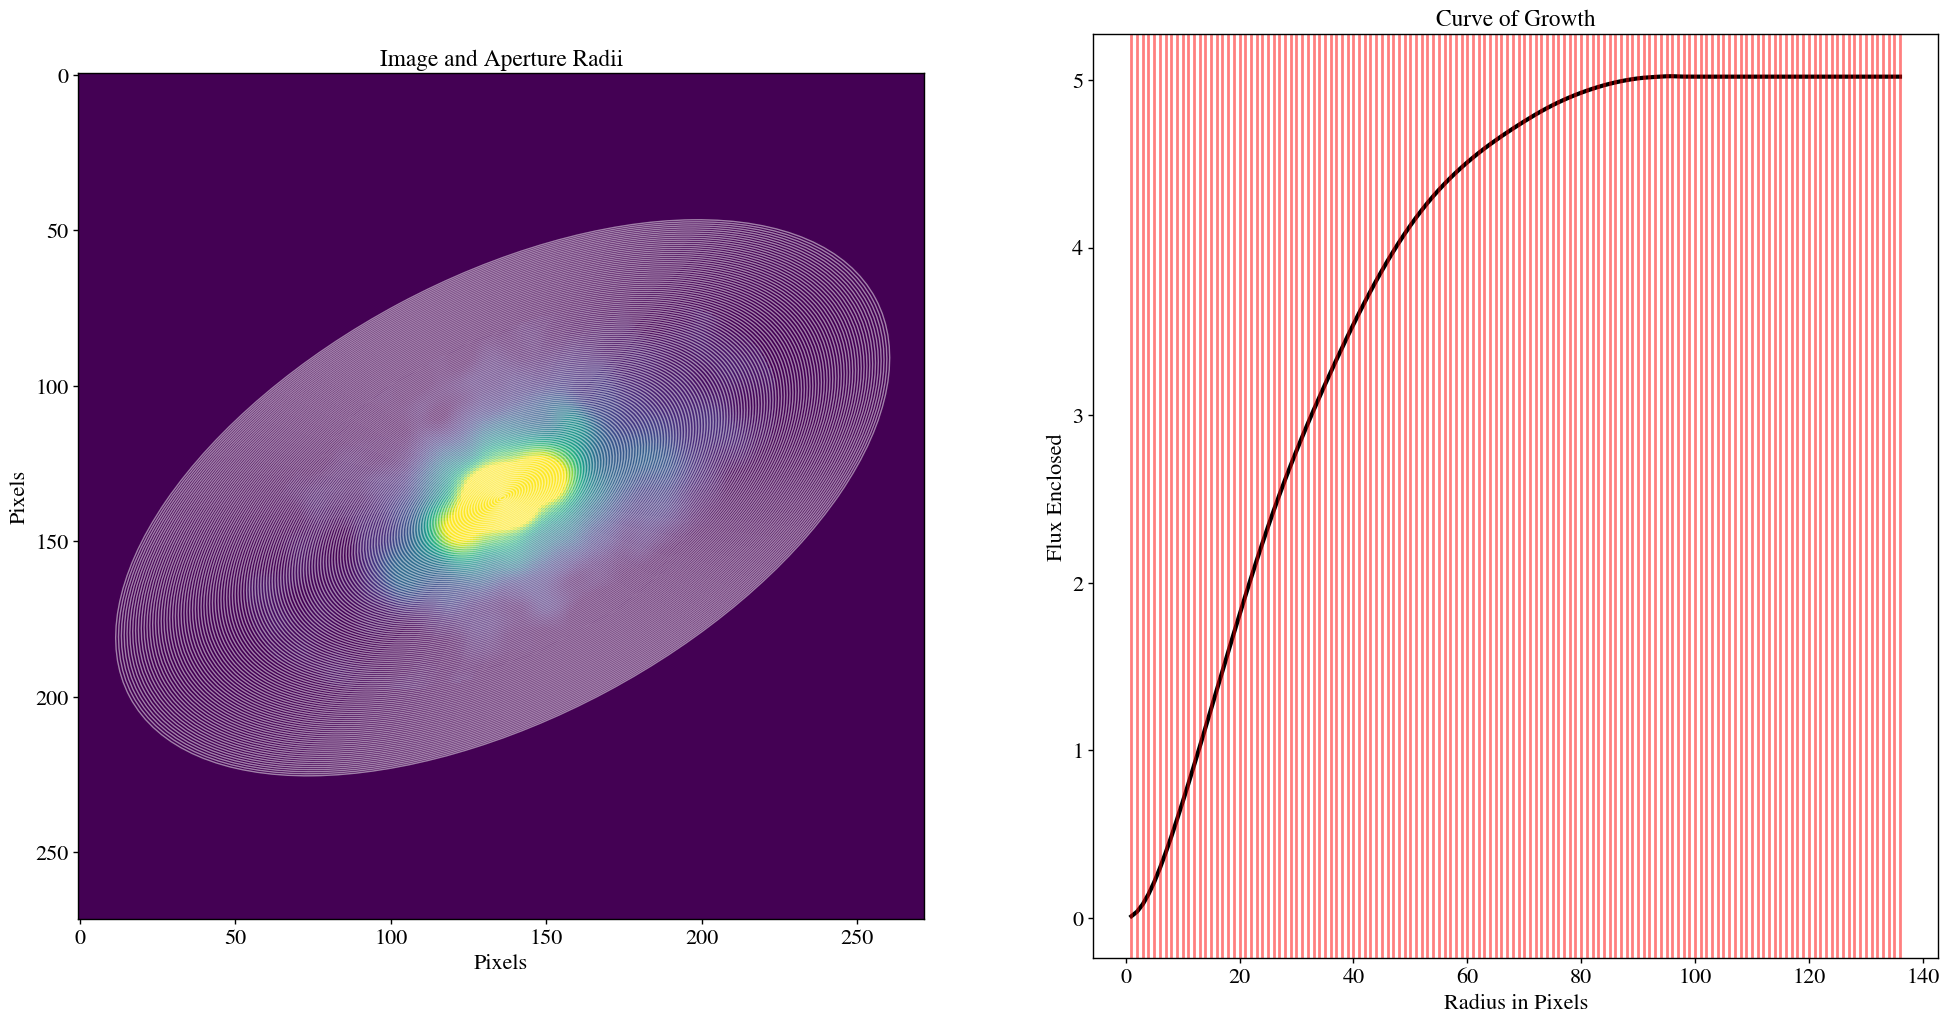

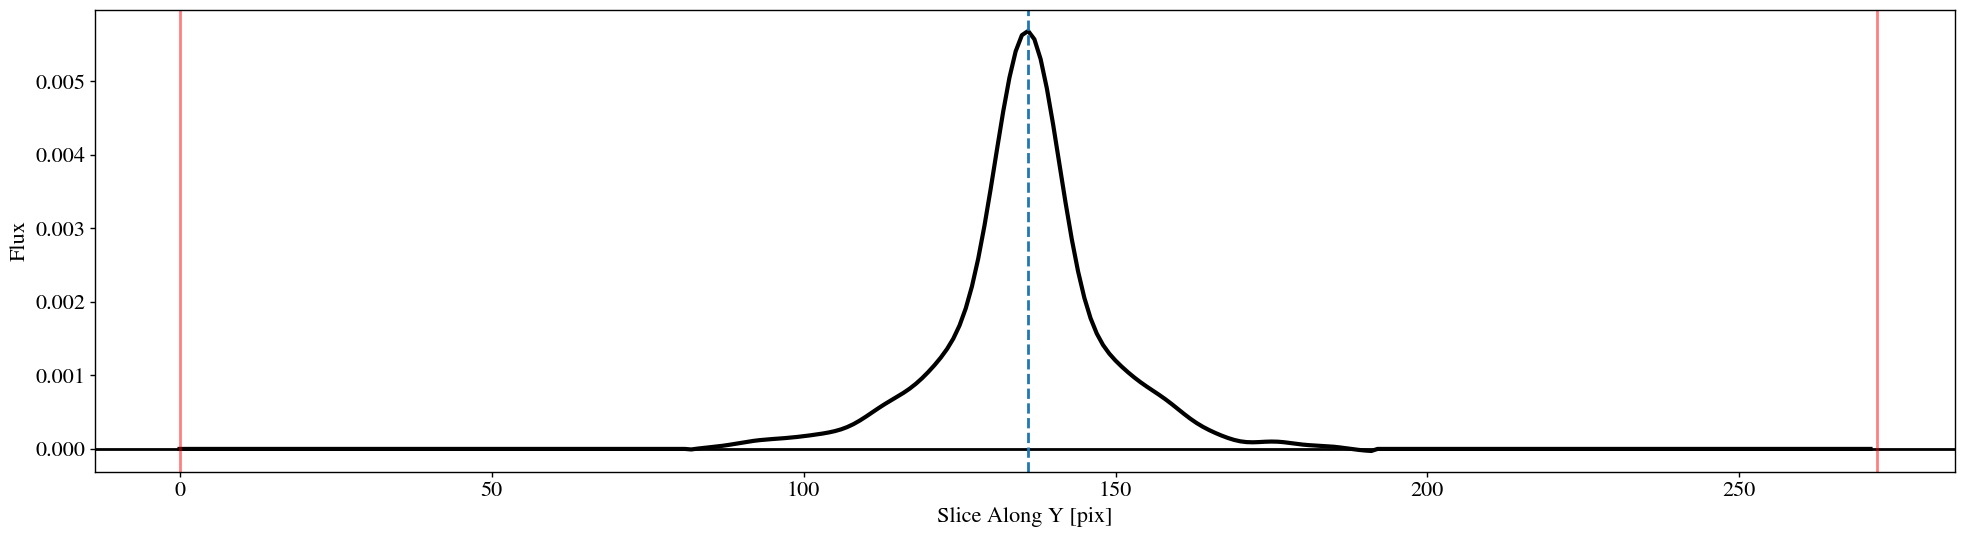

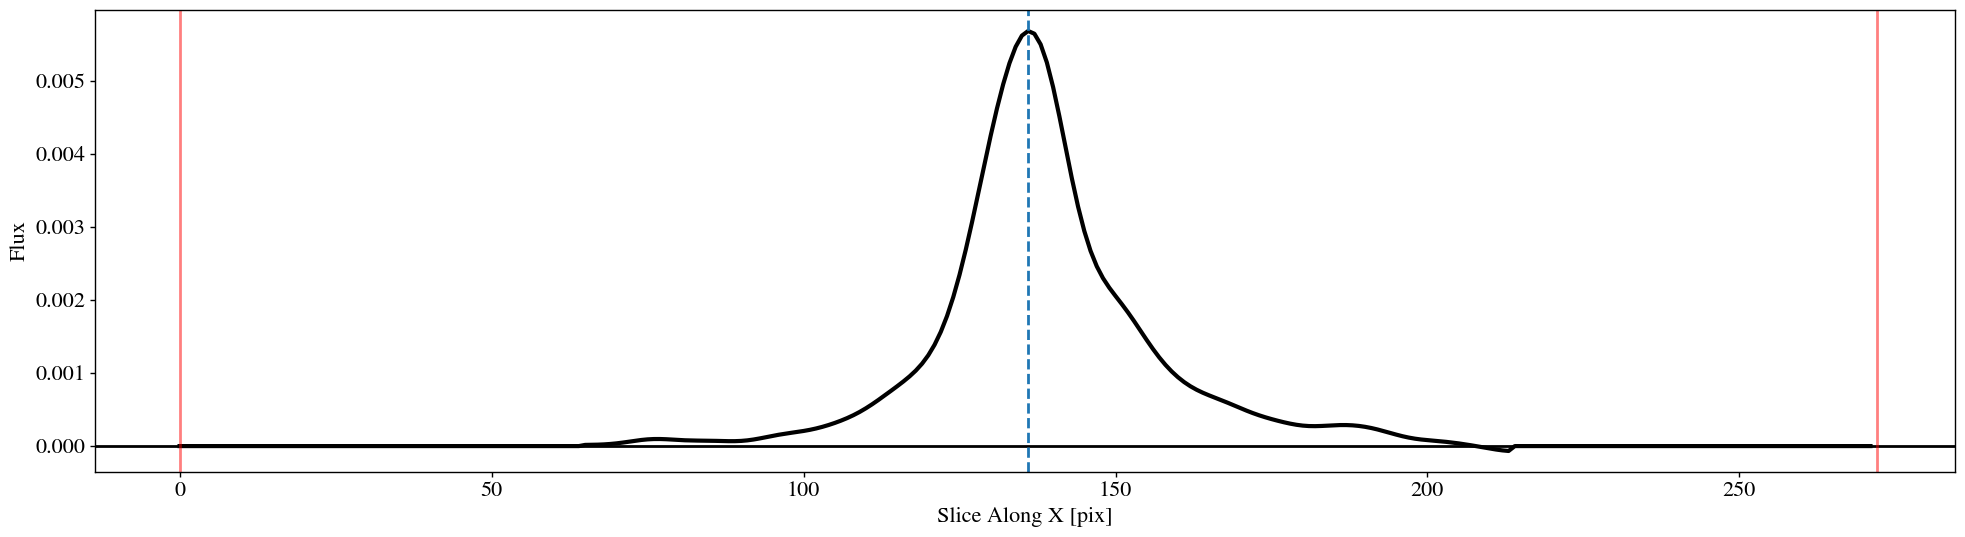

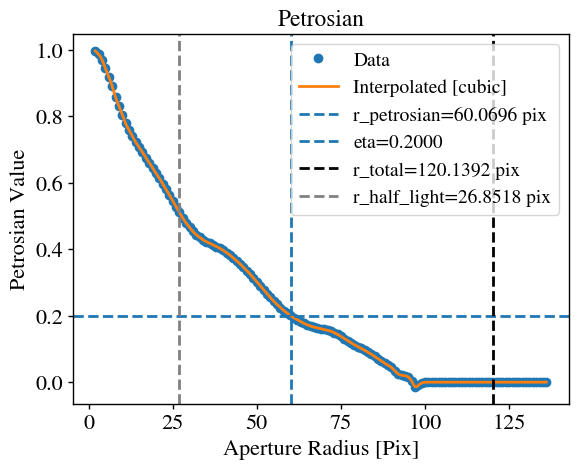

In [20]:
sources_photometry = compute_petro_source(ctn(crop_image),mask_component=mask_component, i=0,plot=True)

In [21]:
sources_photometry

{'c1_PA': -28.111155459327254,
 'c1_q': 0.5201647721564178,
 'c1_area': 13771.0,
 'c1_Re': 66.207593542108,
 'c1_x0c': 516.8320092977332,
 'c1_y0c': 510.44430245513473,
 'c1_label': 1,
 'c1_R50': 26.851770354070812,
 'c1_Snu': 5.019866000000001,
 'c1_Rp': 60.069613922784555,
 'c1_Rpidx': 120,
 'c1_rlast': 136,
 'c1_I50': 0.0005889797424639586}

## Then, we can loop over all components of the radio emission

In [22]:
# i = 0 #to be used in indices[0], e.g. first component
sources_photometies = {} # init dict to store values. 
for i in range(len(indices)):
    # ii = str(i+1)
    mask_component = masks[indices[i]]
    data_component = data_2D*mask_component
    sources_photometies = compute_petro_source(ctn(crop_image),mask_component=mask_component, 
                                              i=i,plot=False,source_props=sources_photometies)
sources_photometies['ncomps'] = len(indices)

/home/sagauga/pCloudDrive/GitHubUoM/phd_lucatelli_work/analysis/libs.py:2164: RuntimeWarning: invalid value encountered in true_divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


In [23]:
sources_photometies

{'c1_PA': -28.111155459327254,
 'c1_q': 0.5201647721564178,
 'c1_area': 13771.0,
 'c1_Re': 66.207593542108,
 'c1_x0c': 516.8320092977332,
 'c1_y0c': 510.44430245513473,
 'c1_label': 1,
 'c1_R50': 26.851770354070812,
 'c1_Snu': 5.019866000000001,
 'c1_Rp': 60.069613922784555,
 'c1_Rpidx': 120,
 'c1_rlast': 136,
 'c1_I50': 0.0005889797424639586,
 'c2_PA': -87.11369843397664,
 'c2_q': 0.8104127604868112,
 'c2_area': 1686.0,
 'c2_Re': 23.16614918595387,
 'c2_x0c': 443.5803920631588,
 'c2_y0c': 391.4536044336015,
 'c2_label': 1,
 'c2_R50': 7.979195839167834,
 'c2_Snu': 0.5532690385518946,
 'c2_Rp': 17.081816363272655,
 'c2_Rpidx': 34,
 'c2_rlast': 48,
 'c2_I50': 0.0010796703718369827,
 'ncomps': 2}

## We have now basic properties of each component of our radio emission:
- `x0 `  : x-coordinate centre position
- `y0 `  : y-coordinate centre position
- `q  `  : axis ratio
- `PA `  : position angle
- `Snu`  : total flux (sum of pixels)
- `Re `  : effective circular area radii 
- `Rp `  : Petrosian Radius
- `R5 ` : half-light radius
- `I5 ` : effective intensity (I at R50)

These parameters will be used to feed the initial hints for the Sersic Decomposition

```
 _____             ____                _          ____                                           _ _   _             
|___ /            / ___|  ___ _ __ ___(_) ___    |  _ \  ___  ___ ___  _ __ ___  _ __   ___  ___(_) |_(_) ___  _ __  
  |_ \    _____   \___ \ / _ \ '__/ __| |/ __|   | | | |/ _ \/ __/ _ \| '_ ` _ \| '_ \ / _ \/ __| | __| |/ _ \| '_ \ 
 ___) |  |_____|   ___) |  __/ |  \__ \ | (__    | |_| |  __/ (_| (_) | | | | | | |_) | (_) \__ \ | |_| | (_) | | | |
|____/            |____/ \___|_|  |___/_|\___|   |____/ \___|\___\___/|_| |_| |_| .__/ \___/|___/_|\__|_|\___/|_| |_|
                                                                                |_|                                  


```

# Using LMFIT Multi Purpose Sersic Decomposition <a id='image-fit-lmfit'></a>

## 2D Multi-Component Sersic Fitting Using Scipy+LMFIT

## This implementation is not easy and quite complex, but the function do_fit2D deals with everything if initial parameters are provided

In [24]:
msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()
cl = casatools.componentlist()
ia = IA()
qa = casatools.quanta()
# ia.open(image)


In [25]:
def create_beam_psf(imname):
    imst = imstat(imname)
    imhd = imhead(imname)
    tb.close()
    direction = "J2000 10h00m00.0s -30d00m00.0s"
    cl.done()
    freq = str(imhd['refval'][2]/1e9)+'GHz'
    majoraxis = str(imhd['restoringbeam']['major']['value'])+str(imhd['restoringbeam']['major']['unit'])
    minoraxis = str(imhd['restoringbeam']['minor']['value'])+str(imhd['restoringbeam']['minor']['unit'])
    pa = str(imhd['restoringbeam']['positionangle']['value'])+str(imhd['restoringbeam']['positionangle']['unit'])
    cl.addcomponent(dir=direction, flux=1.0, fluxunit='Jy', freq=freq,
    shape="Gaussian",majoraxis=majoraxis, minoraxis=minoraxis, positionangle=pa)
    ia.fromshape(imname.replace('-image.cutout.fits','-beampsf.cutout.im'),[151,151,1,1],overwrite=True)
    cs=ia.coordsys()
    cs.setunits(['rad','rad','','Hz'])
    cell_rad=qa.convert(qa.quantity("0.006arcsec"),"rad")['value']
    cs.setincrement([-cell_rad,cell_rad],'direction')
    cs.setreferencevalue([qa.convert("10h",'rad')['value'],qa.convert("-30deg",'rad')['value']],type="direction")
    cs.setreferencevalue(freq,'spectral')
    ia.setcoordsys(cs.torecord())
    ia.setbrightnessunit("Jy/pixel")
    ia.modify(cl.torecord(),subtract=False)
    exportfits(imagename=imname.replace('-image.cutout.fits','-beampsf.cutout.im'),
    fitsimage=imname.replace('-image.cutout.fits','-beampsf.cutout.fits'),overwrite=True)
    cl.close()

In [26]:
create_beam_psf(crop_image)

2023-02-22 02:22:01	WARN	componentlist::close	componentlist closed


### Using Petrosian quantities to Guess Sersic components
Now, lets use those Petrosian estimates to create a sersic model for each sub-component created. 

Effective Radii `R50`
Since, each region have its halg-light radii, we feed its value to the Sersic  effective radii parameter `Rn`

Effective Intensity `I50`
We do the same for the half-light intensity, feeding into the effective intensity parameter `In`

Coordinates, orientation and axis ratio:
We also use these parameters from the Petrosian analysis to provide initial hints and constraints for each Sersic model

In [27]:
n_components = len(indices)
print("# of components to be fitted =", n_components)

# of components to be fitted = 2


In [28]:
sources_photometies

{'c1_PA': -28.111155459327254,
 'c1_q': 0.5201647721564178,
 'c1_area': 13771.0,
 'c1_Re': 66.207593542108,
 'c1_x0c': 516.8320092977332,
 'c1_y0c': 510.44430245513473,
 'c1_label': 1,
 'c1_R50': 26.851770354070812,
 'c1_Snu': 5.019866000000001,
 'c1_Rp': 60.069613922784555,
 'c1_Rpidx': 120,
 'c1_rlast': 136,
 'c1_I50': 0.0005889797424639586,
 'c2_PA': -87.11369843397664,
 'c2_q': 0.8104127604868112,
 'c2_area': 1686.0,
 'c2_Re': 23.16614918595387,
 'c2_x0c': 443.5803920631588,
 'c2_y0c': 391.4536044336015,
 'c2_label': 1,
 'c2_R50': 7.979195839167834,
 'c2_Snu': 0.5532690385518946,
 'c2_Rp': 17.081816363272655,
 'c2_Rpidx': 34,
 'c2_rlast': 48,
 'c2_I50': 0.0010796703718369827,
 'ncomps': 2}

In [29]:
## We use 2 solver methods for better convergence. 
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=crop_image,residualname=crop_residual,
                                                   init_constraints=sources_photometies,
                                                   params_values_init = None,#imfit_conf_values[0:-1],
#                                                    fix_n = False,fix_x0_y0=[False,False,False],
                                                   ncomponents=n_components,constrained=True,
                                                   fix_n=[True,True], #fix both sersic indexes (e.g. 0.5 >> gaussians)
                                                   method1 = 'least_squares',method2 = 'least_squares',
                                                   init_params = 0.25,final_params = 4.0,
                                                   save_name_append='_ls_nfix_IMFIT_opt')

Using clean background for optmization...
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
{'f1_x0': {'value': 516.8320092977332, 'min': 506.8320092977332, 'max': 526.8320092977332}, 'f1_y0': {'value': 510.44430245513473, 'min': 500.44430245513473, 'max': 520.4443024551347}, 'f1_PA': {'value': -28.111155459327254, 'min': -88.11115545932725, 'max': 31.888844540672746}, 'f1_ell': {'value': 0.47983522784358223, 'min': 0.23991761392179112, 'max': 0.9596704556871645}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0005889797424639586, 'min': 0.00011779594849279172, 'max': 0.05889797424639586}, 'f1_Rn': {'value': 26.851770354070812, 'min': 5.370354070814162, 'max': 107.40708141628325}, 'f2_x0': {'value': 443.5803920631588, 'min': 433.5803920631588, 'max': 453.5803920631588}, 'f2_y0': {'value': 391.4536044336015, 'min': 381.4536044336015, 'max': 401.4536044336015}, 'f2_PA': {'val

In [30]:
result_mini

In [31]:
result_mini.params['f1_n'],result_1.params['f1_n'], result_mini.params['f2_n'],result_1.params['f2_n']

(<Parameter 'f1_n', value=0.5099999999999999 +/- 0.00117, bounds=[0.49:0.51]>,
 <Parameter 'f1_n', value=0.5099999999999999 +/- 0.00117, bounds=[0.49:0.51]>,
 <Parameter 'f2_n', value=0.5099999999999999 +/- 0.0182, bounds=[0.49:0.51]>,
 <Parameter 'f2_n', value=0.5099999999999999 +/- 0.0182, bounds=[0.49:0.51]>)

Peak Pos= [512 512]


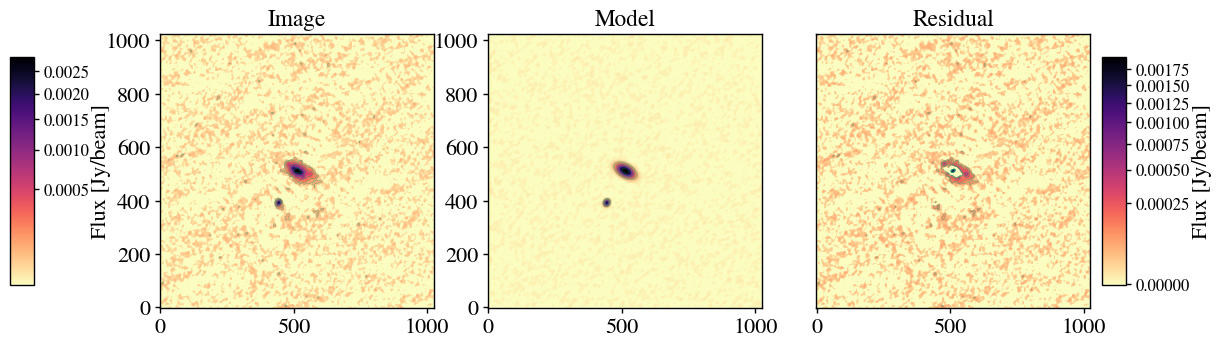

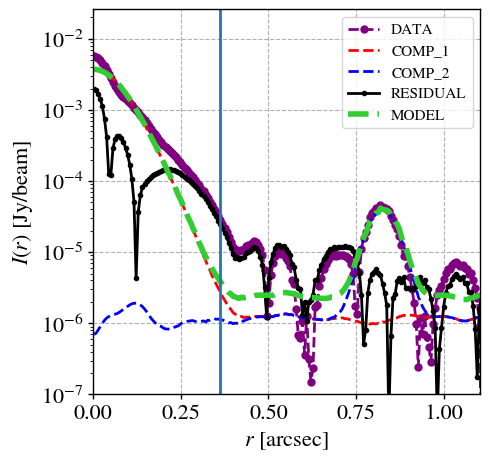

In [32]:
plot_fit_results(crop_image,model_dict,image_results_conv,sources_photometies)

In [33]:
# # configure plotting
# %config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
#                             'figure.figsize': (3, 3 / 1.6), 'font.size': 10, \
#                             'figure.facecolor': (1, 1, 1, 0)}
# %matplotlib inline

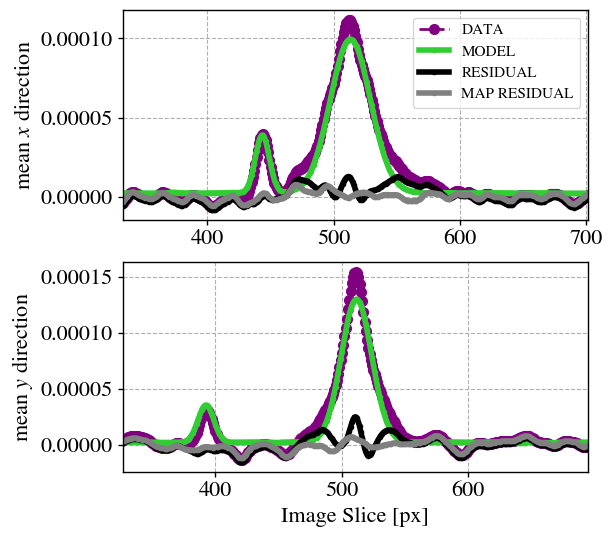

In [34]:
plot_slices(ctn(crop_image),ctn(crop_residual),model_dict,image_results_conv[-2],sources_photometies)

## Fit not good? Maybe, need to add another component?  Sure, no problems....

In [35]:
def add_extra_component(petro_properties, copy_from_id):
    """
    Create another component from a dictionary (petro_properties) having 
    photometric properties for N detected components in an image. 
    
    Params
    ------
    petro_properties: dict
        Contain parameters of a number o N components obtained 
        by a petrosian analysis of all detected sources.
        Example (these are actually the keys() from the dictionary):
        ['c1_PA', 'c1_q', 'c1_area', 'c1_Re', 
        'c1_x0c', 'c1_y0c', 'c1_label', 'c1_R50', 
        'c1_Snu', 'c1_Rp', 'c1_Rpidx', 'c1_rlast', 
        'c1_I50']
    copy_from: int
        From which component copy parameters from.
        This is useful, for example, the source has two components detected, 
        1 compact and the other a structure that can not be modelled by a single 
        sersic function. Then, we need one function to model the compact structure, 
        but 2 sersic functions to model the other structure. 
        
        Assume that we have a blob surrounded by a disky emission (though detected 
        as being one source). Both are placed on the same region, on top of each other 
        (e.g. from optical, we call a bulge and 
        a disk). We need two functions to model this region. 
        
        So, if component i=1 is the blob (or the bulge) we copy the parameters from it and 
        create a second component. We just have to ajust some of the parameters. 
        E.g. the effective radius of this new component, is in principle, larger than the original component. 
        As well, the effective intensity will be smaller because we are adding a component 
        further away from the centre. Other quantities, however, are uncertain, such as the Sersic index, position angle 
        etc, but may be close to those of component i. 
        
    """
    
    from collections import OrderedDict
    dict_keys = list(petro_properties.keys())
    unique_list = list(OrderedDict.fromkeys([elem.split('_')[1] for elem in dict_keys if '_' in elem]))
#     print(unique_list)

    petro_properties_copy = petro_properties.copy()
    new_comp_id = sources_photometies['ncomps'] + 1
    for k in range(len(unique_list)):
#         print(unique_list[k])
        # do not change anything for other parameters. 
        petro_properties_copy['c'+str(new_comp_id)+'_'+unique_list[k]] = petro_properties_copy['c'+str(copy_from_id)+'_'+unique_list[k]]
        if unique_list[k] == 'R50':
            # multiply the R50 value by a factor, e.g., 2.0
            factor = 2
            petro_properties_copy['c'+str(new_comp_id)+'_'+unique_list[k]] = petro_properties_copy['c'+str(copy_from_id)+'_'+unique_list[k]]*factor
        if unique_list[k] == 'I50':
            # divide the I50 value by a factor, e.g., 2
            factor = 0.5
            petro_properties_copy['c'+str(new_comp_id)+'_'+unique_list[k]] = petro_properties_copy['c'+str(copy_from_id)+'_'+unique_list[k]]*factor
    #update number of components
    petro_properties_copy['ncomps'] = petro_properties_copy['ncomps'] + 1
    return(petro_properties_copy)

In [36]:
sources_photometies_new = add_extra_component(sources_photometies,copy_from_id=1)
sources_photometies_new

{'c1_PA': -28.111155459327254,
 'c1_q': 0.5201647721564178,
 'c1_area': 13771.0,
 'c1_Re': 66.207593542108,
 'c1_x0c': 516.8320092977332,
 'c1_y0c': 510.44430245513473,
 'c1_label': 1,
 'c1_R50': 26.851770354070812,
 'c1_Snu': 5.019866000000001,
 'c1_Rp': 60.069613922784555,
 'c1_Rpidx': 120,
 'c1_rlast': 136,
 'c1_I50': 0.0005889797424639586,
 'c2_PA': -87.11369843397664,
 'c2_q': 0.8104127604868112,
 'c2_area': 1686.0,
 'c2_Re': 23.16614918595387,
 'c2_x0c': 443.5803920631588,
 'c2_y0c': 391.4536044336015,
 'c2_label': 1,
 'c2_R50': 7.979195839167834,
 'c2_Snu': 0.5532690385518946,
 'c2_Rp': 17.081816363272655,
 'c2_Rpidx': 34,
 'c2_rlast': 48,
 'c2_I50': 0.0010796703718369827,
 'ncomps': 3,
 'c3_PA': -28.111155459327254,
 'c3_q': 0.5201647721564178,
 'c3_area': 13771.0,
 'c3_Re': 66.207593542108,
 'c3_x0c': 516.8320092977332,
 'c3_y0c': 510.44430245513473,
 'c3_label': 1,
 'c3_R50': 53.703540708141624,
 'c3_Snu': 5.019866000000001,
 'c3_Rp': 60.069613922784555,
 'c3_Rpidx': 120,
 'c

In [37]:
n_components_new = sources_photometies_new['ncomps']
print("# of components to be fitted =", n_components_new)

# of components to be fitted = 3


In [38]:
sources_photometies_new

{'c1_PA': -28.111155459327254,
 'c1_q': 0.5201647721564178,
 'c1_area': 13771.0,
 'c1_Re': 66.207593542108,
 'c1_x0c': 516.8320092977332,
 'c1_y0c': 510.44430245513473,
 'c1_label': 1,
 'c1_R50': 26.851770354070812,
 'c1_Snu': 5.019866000000001,
 'c1_Rp': 60.069613922784555,
 'c1_Rpidx': 120,
 'c1_rlast': 136,
 'c1_I50': 0.0005889797424639586,
 'c2_PA': -87.11369843397664,
 'c2_q': 0.8104127604868112,
 'c2_area': 1686.0,
 'c2_Re': 23.16614918595387,
 'c2_x0c': 443.5803920631588,
 'c2_y0c': 391.4536044336015,
 'c2_label': 1,
 'c2_R50': 7.979195839167834,
 'c2_Snu': 0.5532690385518946,
 'c2_Rp': 17.081816363272655,
 'c2_Rpidx': 34,
 'c2_rlast': 48,
 'c2_I50': 0.0010796703718369827,
 'ncomps': 3,
 'c3_PA': -28.111155459327254,
 'c3_q': 0.5201647721564178,
 'c3_area': 13771.0,
 'c3_Re': 66.207593542108,
 'c3_x0c': 516.8320092977332,
 'c3_y0c': 510.44430245513473,
 'c3_label': 1,
 'c3_R50': 53.703540708141624,
 'c3_Snu': 5.019866000000001,
 'c3_Rp': 60.069613922784555,
 'c3_Rpidx': 120,
 'c

In [39]:
"""
Run the fitting again.
"""
## We use 2 solver methods for better convergence. 
result_mini, mini,result_1,result_extra,model_dict, \
image_results_conv,image_results_deconv = do_fit2D(imagename=crop_image,residualname=crop_residual,
                                                   init_constraints=sources_photometies_new,
                                                   params_values_init = None,#imfit_conf_values[0:-1],
#                                                    fix_n = False,fix_x0_y0=[False,False,False],
                                                   ncomponents=n_components_new,constrained=True,
                                                   fix_n=[True,True,False], #do not fix the n of the extra component
                                                   method1 = 'least_squares',method2 = 'least_squares',
                                                   init_params = 0.25,final_params = 4.0,
                                                   save_name_append='_ls_nfix_IMFIT_opt')

Using clean background for optmization...
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
{'f1_x0': {'value': 516.8320092977332, 'min': 506.8320092977332, 'max': 526.8320092977332}, 'f1_y0': {'value': 510.44430245513473, 'min': 500.44430245513473, 'max': 520.4443024551347}, 'f1_PA': {'value': -28.111155459327254, 'min': -88.11115545932725, 'max': 31.888844540672746}, 'f1_ell': {'value': 0.47983522784358223, 'min': 0.23991761392179112, 'max': 0.9596704556871645}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0005889797424639586, 'min': 0.00011779594849279172, 'max': 0.05889797424639586}, 'f1_Rn': {'value': 26.851770354070812, 'min': 5.370354070814162, 'max': 107.40708141628325}, 'f2_x0': {'value': 443.5803920631588, 'min': 433.5803920631588, 'max': 453.5803920631588}, 'f2_y0': {'value': 391.4536044336015, 'min': 381.4536044336015, 'max': 401.4536

      66             80         3.7092e-04      3.03e-14       1.32e-04       1.97e-09    
      67             81         3.7092e-04      5.55e-15       2.57e-04       6.27e-10    
      68             82         3.7092e-04      1.03e-15       1.03e-05       4.80e-10    
      69             83         3.7092e-04      7.50e-16       7.21e-05       3.10e-10    
      70             86         3.7092e-04      3.25e-19       9.58e-06       1.84e-10    
      71             87         3.7092e-04      1.12e-17       2.71e-06       1.68e-10    
`ftol` termination condition is satisfied.
Function evaluations 87, initial cost 3.2728e-02, final cost 3.7092e-04, first-order optimality 1.68e-10.
 >> Using least_squares  solver for second optimisation run... 
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7092e-04                                    1.70e-10    
       1              2         3.7092e-04      9.67e-15   

In [40]:
result_mini

Peak Pos= [512 512]


(0.0, 1.0)

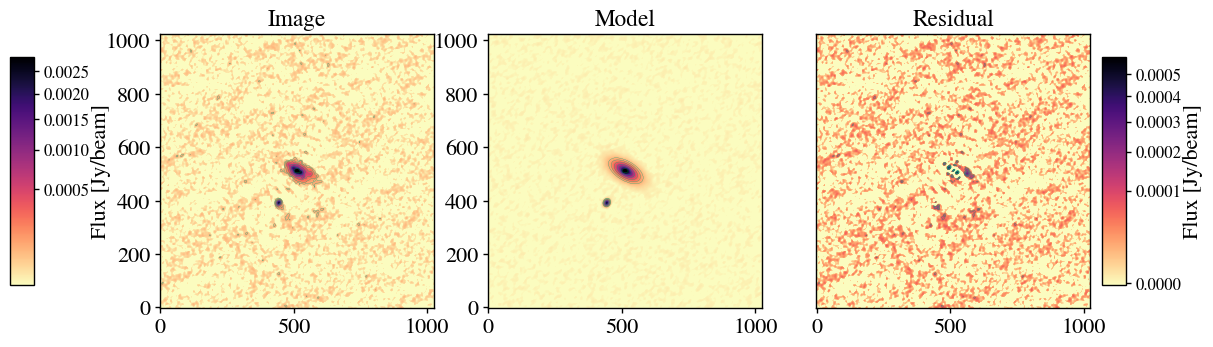

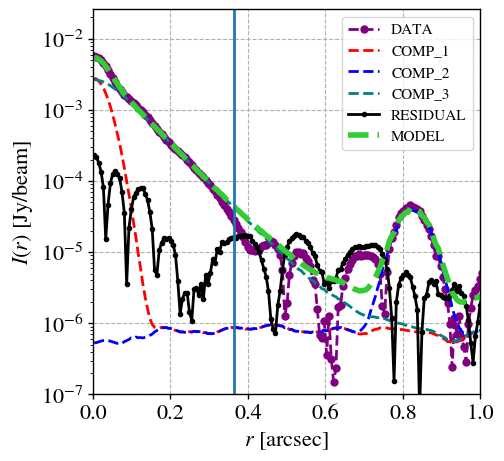

In [41]:
plot_fit_results(crop_image,model_dict,image_results_conv,sources_photometies_new)
plt.xlim(0,1)

In [42]:
# # configure plotting
# %config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
#                             'figure.figsize': (3, 3 / 1.6), 'font.size': 10, \
#                             'figure.facecolor': (1, 1, 1, 0)}
# %matplotlib inline

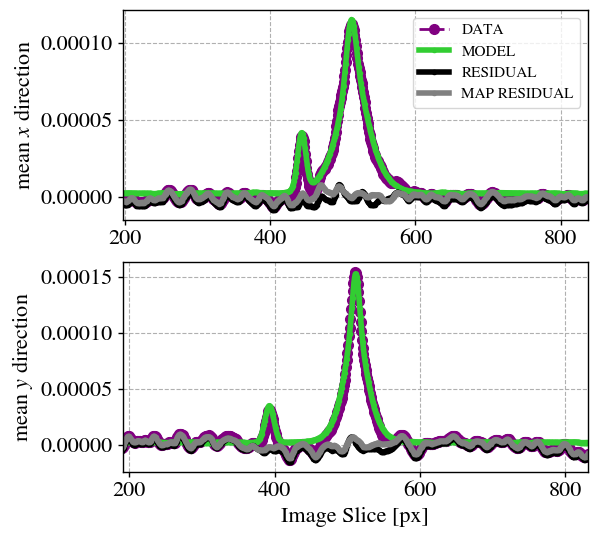

In [43]:
plot_slices(ctn(crop_image),ctn(crop_residual),model_dict,image_results_conv[-2],sources_photometies_new)

```
 ▄▄▄          ███▄ ▄███▓    ▄▄▄         ▒███████▒    ██▓    ███▄    █      ▄████ 
▒████▄       ▓██▒▀█▀ ██▒   ▒████▄       ▒ ▒ ▒ ▄▀░   ▓██▒    ██ ▀█   █     ██▒ ▀█▒
▒██  ▀█▄     ▓██    ▓██░   ▒██  ▀█▄     ░ ▒ ▄▀▒░    ▒██▒   ▓██  ▀█ ██▒   ▒██░▄▄▄░
░██▄▄▄▄██    ▒██    ▒██    ░██▄▄▄▄██      ▄▀▒   ░   ░██░   ▓██▒  ▐▌██▒   ░▓█  ██▓
 ▓█   ▓██▒   ▒██▒   ░██▒    ▓█   ▓██▒   ▒███████▒   ░██░   ▒██░   ▓██░   ░▒▓███▀▒
 ▒▒   ▓▒█░   ░ ▒░   ░  ░    ▒▒   ▓▒█░   ░▒▒ ▓░▒░▒   ░▓     ░ ▒░   ▒ ▒     ░▒   ▒ 
  ▒   ▒▒ ░   ░  ░      ░     ▒   ▒▒ ░   ░░▒ ▒ ░ ▒    ▒ ░   ░ ░░   ░ ▒░     ░   ░ 
  ░   ▒      ░      ░        ░   ▒      ░ ░ ░ ░ ░    ▒ ░      ░   ░ ░    ░ ░   ░ 
      ░  ░          ░            ░  ░     ░ ░        ░              ░          ░ 
                                        ░                                        
                      

```